In [0]:
COLAB = True # NOTE change me if not running on Colab :D

In [2]:
if COLAB:
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    print("vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv")
    print("                                Hey!                                ")
    print("        Don't forget Google Drive's authorization code below        ")
    print("                                 ;)                                 ")
    print("^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^")
    print("||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
                                Hey!                                
        Don't forget Google Drive's authorization code below        
                                 ;)                                 
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


## Importing libs

In [0]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

In [5]:
if COLAB:
    try:
        # Colab only
        %tensorflow_version 2.x
    except Exception:
        pass

TensorFlow 2.x selected.


In [6]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.0.0


In [0]:
import warnings
from time import time, strftime

In [8]:
strftime('%X')

'18:22:15'

## Preparing the Fashion-MNIST dataset
[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando’s article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

**NOTE:** you should have the .csv files in the directory listed below

In [9]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
# confirm that you have fashion-mnist_train.csv and fashion-mnist_test.csv (unzipped)
if COLAB:
    PATH_TO_DATA = os.path.join("drive", "My Drive", "unicamp", "%ic", "mc886", "fashion-mnist-dataset")
    !ls drive/My\ Drive/unicamp/%ic/mc886/fashion-mnist-dataset/
else:
    PATH_TO_DATA = os.path.join("..", "fashion-mnist-dataset")
    !ls ../fashion-mnist-dataset/

fashion-mnist_test.csv	fashion-mnist_train.csv  README.txt


In [0]:
# the datasets have the label on the first column and the image pixels on the following 784
train_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_train.csv"), delimiter=',')
test_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_test.csv"), delimiter=',')

In [0]:
IMG_WIDTH = IMG_HEIGHT = 28
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH) # grayscale images
IMG_FLAT_SHAPE = (IMG_HEIGHT*IMG_WIDTH, )

CLASS_NAME = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
CLASS_COUNT = len(CLASS_NAME)

## Split train into train + validation

In [0]:
# random seed for splitting the data deterministically
RANDOM_SEED = 886
np.random.seed(RANDOM_SEED)

In [14]:
from sklearn.model_selection import train_test_split

train_dataset, validation_dataset = train_test_split(train_dataset_csv, train_size=0.8, shuffle=True, random_state=RANDOM_SEED)
print(f"train:      {train_dataset.shape}") # 80%
print(f"validation: {validation_dataset.shape}") # 20%

test_dataset = test_dataset_csv
print(f"test:       {test_dataset.shape}")

train:      (48000, 785)
validation: (12000, 785)
test:       (10000, 785)


## Separate labels and images

In [15]:
ys_train = train_dataset["label"].values
ys_val   = validation_dataset["label"].values
ys_test  = test_dataset["label"].values

print(ys_train.shape, "min:", ys_train.min(), "max:", ys_train.max())
print(ys_val.shape,   "min:", ys_val.min(),   "max:", ys_val.max())
print(ys_test.shape,  "min:", ys_test.min(),  "max:", ys_test.max())

(48000,) min: 0 max: 9
(12000,) min: 0 max: 9
(10000,) min: 0 max: 9


In [16]:
xs_train = train_dataset.loc[:, train_dataset.columns != "label"].values
xs_val   = validation_dataset.loc[:, validation_dataset.columns != "label"].values
xs_test  = test_dataset.loc[:, test_dataset.columns != "label"].values

print(xs_train.shape, "min:", xs_train.min(), "max:", xs_train.max())
print(xs_val.shape,   "min:", xs_val.min(),   "max:", xs_val.max())
print(xs_test.shape,  "min:", xs_test.min(),  "max:", xs_test.max())

(48000, 784) min: 0 max: 255
(12000, 784) min: 0 max: 255
(10000, 784) min: 0 max: 255


In [0]:
def each_count(array):
    count = np.bincount(array)
    nonzero_count = np.nonzero(count)[0]
    return zip(nonzero_count, count[nonzero_count])

In [18]:
class_count_train = list(each_count(ys_train))
class_count_val   = list(each_count(ys_val))
class_count_test  = list(each_count(ys_test))
print("              Train         Validation    Test")
for label in range(CLASS_COUNT):
    print(f"{(CLASS_NAME[label] + ':'):<12}  "
          f"{class_count_train[label][1]} ({class_count_train[label][1] / ys_train.shape[0]:.2f}%)  "
          f"{class_count_val[label][1]} ({class_count_val[label][1] / ys_val.shape[0]:.2f}%)  "
          f"{class_count_test[label][1]} ({class_count_test[label][1] / ys_test.shape[0]:.2f}%)")

              Train         Validation    Test
T-shirt/top:  4863 (0.10%)  1137 (0.09%)  1000 (0.10%)
Trouser:      4795 (0.10%)  1205 (0.10%)  1000 (0.10%)
Pullover:     4817 (0.10%)  1183 (0.10%)  1000 (0.10%)
Dress:        4770 (0.10%)  1230 (0.10%)  1000 (0.10%)
Coat:         4820 (0.10%)  1180 (0.10%)  1000 (0.10%)
Sandal:       4769 (0.10%)  1231 (0.10%)  1000 (0.10%)
Shirt:        4771 (0.10%)  1229 (0.10%)  1000 (0.10%)
Sneaker:      4764 (0.10%)  1236 (0.10%)  1000 (0.10%)
Bag:          4778 (0.10%)  1222 (0.10%)  1000 (0.10%)
Ankle boot:   4853 (0.10%)  1147 (0.10%)  1000 (0.10%)


## Normalize images and one-hot encode labels

In [0]:
xs_train = xs_train.astype('float32') / 255.0
xs_val   = xs_val.astype('float32')   / 255.0
xs_test  = xs_test.astype('float32')  / 255.0

**Let's forget about the test set for now..** just assume it doesn't exist (but don't worry, we'll come back to it at the end).

In [20]:
print(f"xs_train: mean={xs_train.mean():>8.4f}, stddev={xs_train.std():>7.4f}")

# NOTE that we must use stats from train data to normalize the val and test sets aswell
mean, std = xs_train.mean(), xs_train.std()
X_train = (xs_train - mean) / std

print(f"X_train:  mean={X_train.mean():>8.4f}, stddev={X_train.std():>7.4f}")

xs_train: mean=  0.2862, stddev= 0.3529
X_train:  mean=  0.0000, stddev= 1.0000


In [21]:
X_val = (xs_val - mean) / std
print(f"xs_val: mean={xs_val.mean():>8.4f}, stddev={xs_val.std():>7.4f}")
print(f"X_val:  mean={X_val.mean():>8.4f}, stddev={X_val.std():>7.4f}") # mean should be close to 0 and stddev close to 1

xs_val: mean=  0.2858, stddev= 0.3526
X_val:  mean= -0.0011, stddev= 0.9992


In [0]:
def onehot_encode(ys):
    n_examples, *_ = ys.shape
    onehot = np.zeros(shape=(n_examples, CLASS_COUNT))
    onehot[np.arange(n_examples), ys] = 1
    return onehot

In [23]:
Y_train = onehot_encode(ys_train)
print(ys_train.shape, Y_train.shape)

(48000,) (48000, 10)


In [24]:
Y_val = onehot_encode(ys_val)
print(ys_val.shape, Y_val.shape)

(12000,) (12000, 10)


_obs.:_ `Y_foo` is only a one-hot encoded version of `ys_foo` (so we use `ys_foo` in some places below, to avoid calling `np.argmax`)

## Add helper functions

In [0]:
def plot_history(history, model=None, n_epochs=None, batch_size=None, title_prefix=None):
    plot_title = ("" if title_prefix is None else (title_prefix + "\n")) + "Train history"
    info = []
    if n_epochs is not None:
        info.append(f"{n_epochs} epochs")
    if batch_size is not None:
        info.append(f"{batch_size} batch size")
    if model is not None:
        info.append(f"{model.optimizer.get_config()['name']} optimizer")
    if len(info) > 0:
        plot_title += f" ({', '.join(info)})"
    
    # leave only "loss" and "val_loss" for plotting
    loss_data = pd.DataFrame({k: v for k, v in history.items() if (k == "loss" or k == "val_loss")})
    loss_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=loss_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Loss" + f" ({model.loss})" if model is not None else "")
    plt.show()

    # leave only "accuracy" and "val_accuracy" for plotting
    acc_data = pd.DataFrame({k: v for k, v in history.items() if (k == "accuracy" or k == "val_accuracy")})
    acc_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=acc_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Accuracy")
    plt.show()

In [0]:
def plot_image_with_prediction(xs, ys, ys_pred, num_rows=5, num_cols=3):
    # ref.: https://www.tensorflow.org/tutorials/keras/classification
    
    def plot_image(i, predictions_array, true_label, img):
        true_label, img = true_label[i], img[i]
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img.reshape(IMG_SHAPE), cmap=plt.cm.binary)
        predicted_label = np.argmax(predictions_array)
        color = 'blue' if predicted_label == true_label else 'red'
        plt.xlabel("{} {:2.0f}% ({})".format(CLASS_NAME[predicted_label],
                                             100*np.max(predictions_array),
                                             CLASS_NAME[true_label]),
                                             color=color)

    def plot_value_array(i, predictions_array, true_label):
        true_label = true_label[i]
        plt.grid(False)
        plt.xticks(range(10))
        plt.yticks([])
        thisplot = plt.bar(range(10), predictions_array, color="#777777")
        plt.ylim([0, 1])
        predicted_label = np.argmax(predictions_array)
        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('blue')
    
    # plot the first few test images, their predicted labels, and the true labels
    # color correct predictions in blue and incorrect predictions in red    
    num_images = num_rows * num_cols
    plt.figure(figsize=(4 * num_cols, 2 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plot_image(i, ys_pred[i], ys, xs)
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_value_array(i, ys_pred[i], ys)
    plt.tight_layout()
    plt.show()

In [0]:
from sklearn.metrics import confusion_matrix, f1_score

In [0]:
def print_cm(ys, ys_pred, class_names, figsize=(10, 9), fontsize=12):
    #cm = confusion_matrix(ys, ys_pred)
    #df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm = np.flip(confusion_matrix(ys, ys_pred), axis=0)
    df_cm = pd.DataFrame(cm, index=class_names[::-1], columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylim(*heatmap.get_xlim())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## 1. Baseline
Explore Neural Networks with Fashion-MNIST. What is the accuracy? Describe your Neural Network architecture.

In [0]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.regularizers import l1, l2

In [0]:
MAX_EPOCHS = 64
BATCH_SIZE = 512
TF_VERBOSE = 1 # 0 = silent, 1 = progress bar, 2 = one line per epoch

In [0]:
def train(model, X_train, Y_train, X_val, Y_val, n_epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, 
          min_delta=0.003, patience=3, early_stopping=True, plot_title=None, plot=True):
    best_model_path = os.path.join("models", f"best_model_{model.name}.h5")
    if not os.path.exists(os.path.dirname(best_model_path)):
        os.makedirs(os.path.dirname(best_model_path))
    
    callbacks = ([keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=best_model_path, save_best_only=True)]
                 if not early_stopping else
                 [keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=best_model_path, save_best_only=True),
                  keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience)])
    
    print("Starting to train...")
    start = time()
    hist = model.fit(
        x=X_train, y=Y_train,
        validation_data=(X_val, Y_val),
        epochs=n_epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=TF_VERBOSE
    ).history
    end = time()
    print(f"\nDone.\nTraining took {(end - start):.2f}s")
    
    if os.path.exists(best_model_path):
        model = keras.models.load_model(best_model_path)
    
    if plot:
        plot_history(hist, model, n_epochs, batch_size, plot_title)
    
    return hist, model

### 1.1. MLP

In [0]:
model = keras.Sequential([
    Input(IMG_FLAT_SHAPE), # 28 * 28 = 784 pixels
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "MLP_baseline")

In [0]:
# NOTE use 'categorical_crossentropy' since `labels` is a one-hot encoded vector
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "MLP_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

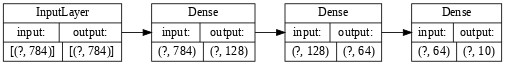

In [36]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60)

In [37]:
strftime('%X')

'18:23:47'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 3s 53us/sample - loss: 0.6343 - accuracy: 0.7823 - val_loss: 0.4527 - val_accuracy: 0.8436
Epoch 2/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.4170 - accuracy: 0.8552 - val_loss: 0.4146 - val_accuracy: 0.8562
Epoch 3/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3769 - accuracy: 0.8693 - val_loss: 0.3939 - val_accuracy: 0.8599
Epoch 4/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3493 - accuracy: 0.8785 - val_loss: 0.3664 - val_accuracy: 0.8701
Epoch 5/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3297 - accuracy: 0.8845 - val_loss: 0.3645 - val_accuracy: 0.8710
Epoch 6/64
48000/48000 [==============================] - 1s 13us/sample - loss: 0.3095 - accuracy: 0.8919 - val_loss: 0.3442 - val_accuracy: 0.8801
Epoch 7/64
48000/48000 [===========

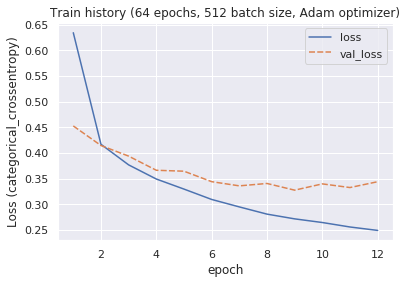

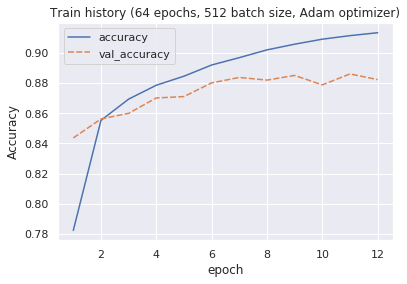

In [38]:
history, best_model = train(model, X_train, Y_train, X_val, Y_val)

In [39]:
strftime('%X')

'18:23:58'

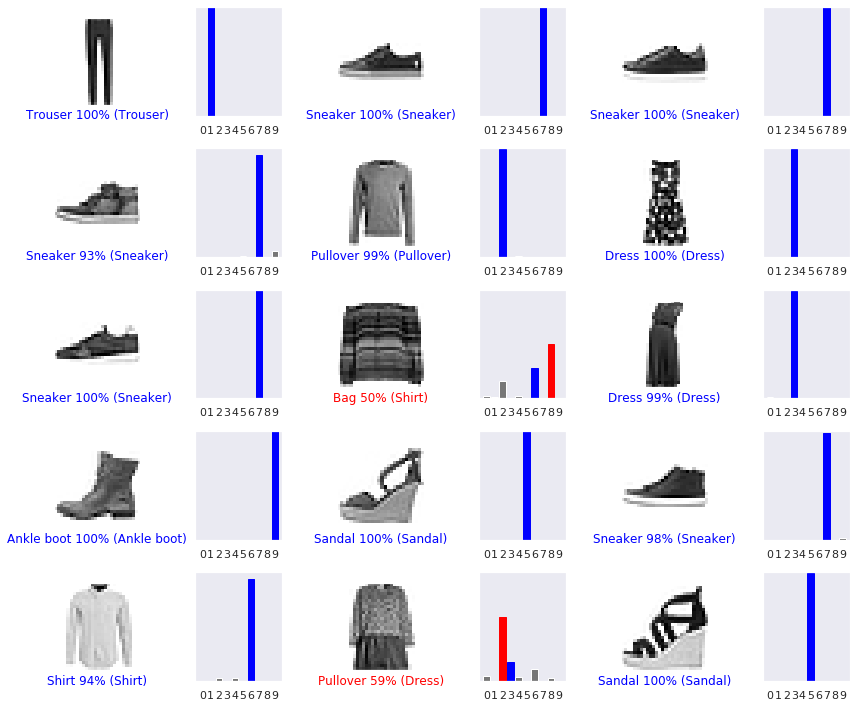

In [40]:
Y_val_pred = best_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_pred)

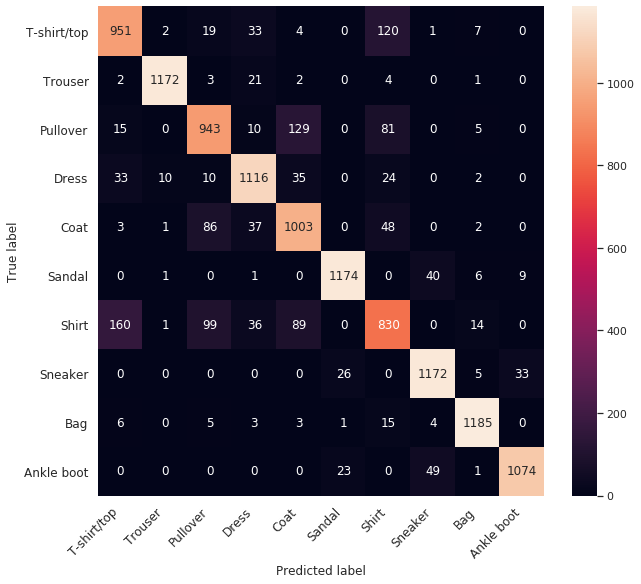

In [41]:
print_cm(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

### 1.2. CNN

In [0]:
# obs.: padding='valid' by default (i.e. no padding)
conv_model = keras.Sequential([
    Reshape((28, 28, 1), input_shape=(784,)),
    Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)), # 28x28 -> 14x14 feature map
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)), # 14x14 -> 7x7 feature map
    Flatten(), # 7*7*64 = 3136
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "CNN_baseline")

In [0]:
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [44]:
conv_model.summary()

Model: "CNN_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [45]:
conv_model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.001,
 'name': 'Adam'}

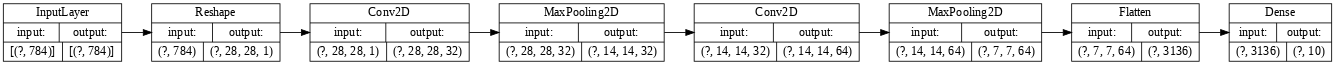

In [46]:
tf.keras.utils.plot_model(conv_model, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60)

In [47]:
strftime('%X')

'18:24:03'

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 6s 128us/sample - loss: 0.7226 - accuracy: 0.7630 - val_loss: 0.4759 - val_accuracy: 0.8388
Epoch 2/64
48000/48000 [==============================] - 2s 50us/sample - loss: 0.4306 - accuracy: 0.8559 - val_loss: 0.4282 - val_accuracy: 0.8536
Epoch 3/64
48000/48000 [==============================] - 2s 50us/sample - loss: 0.3913 - accuracy: 0.8709 - val_loss: 0.3663 - val_accuracy: 0.8790
Epoch 4/64
48000/48000 [==============================] - 2s 50us/sample - loss: 0.3594 - accuracy: 0.8818 - val_loss: 0.3529 - val_accuracy: 0.8840
Epoch 5/64
48000/48000 [==============================] - 2s 50us/sample - loss: 0.3375 - accuracy: 0.8895 - val_loss: 0.3368 - val_accuracy: 0.8893
Epoch 6/64
48000/48000 [==============================] - 2s 50us/sample - loss: 0.3219 - accuracy: 0.8958 - val_loss: 0.3384 - val_accuracy: 0.8898
Epoch 7/64
48000/48000 [==========

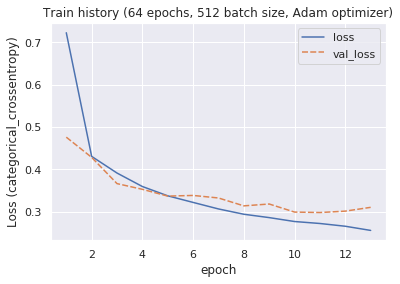

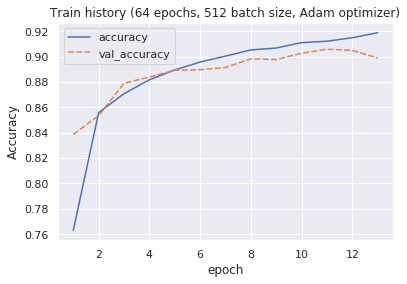

In [48]:
conv_history, best_conv_model = train(conv_model, X_train, Y_train, X_val, Y_val)

In [49]:
strftime('%X')

'18:24:40'

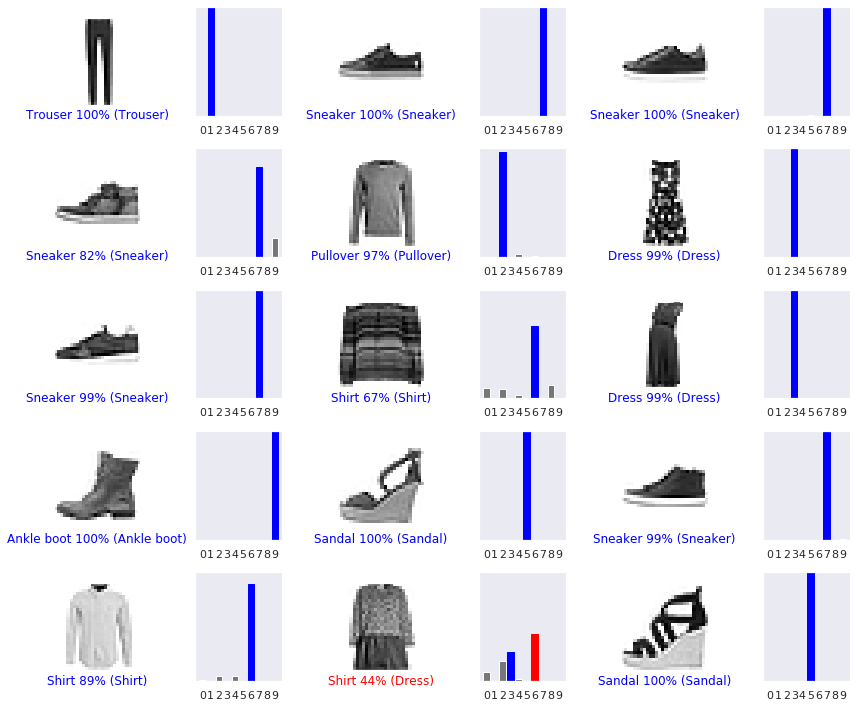

In [50]:
Y_val_conv_pred = best_conv_model.predict(X_val)
plot_image_with_prediction(X_val, ys_val, Y_val_conv_pred)

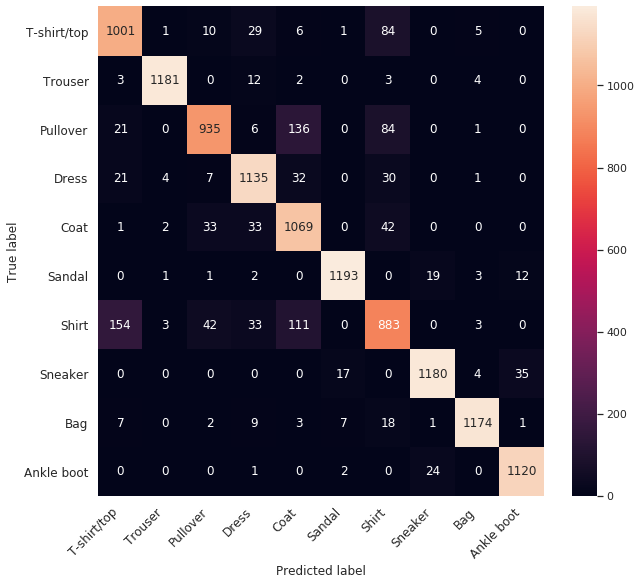

In [51]:
print_cm(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

## 2. Using PCA
Re-do the ﬁrst experiment considering the PCA dimensionality reduction. Consider three diﬀerent energies (variance) for reducing the image dimensionality. What are the conclusions when using PCA in this problem? Does the accuracy improve?

In [0]:
from sklearn.decomposition import PCA

In [0]:
def print_info(array, name):
    print(f"{name+':':<9} {array.dtype.name:<7} {str(array.shape):<12} "
          f"| min: {array.min():>5.2f} | max: {array.max():>5.2f} "
          f"| mean: {array.mean():>5.3f} | std: {array.std():>5.3f}")

In [54]:
print_info(X_train, "X_train")
print_info(xs_train, "xs_train")
print_info(Y_train, "Y_train")
print_info(ys_train, "ys_train")

X_train:  float32 (48000, 784) | min: -0.81 | max:  2.02 | mean: 0.000 | std: 1.000
xs_train: float32 (48000, 784) | min:  0.00 | max:  1.00 | mean: 0.286 | std: 0.353
Y_train:  float64 (48000, 10)  | min:  0.00 | max:  1.00 | mean: 0.100 | std: 0.300
ys_train: int64   (48000,)     | min:  0.00 | max:  9.00 | mean: 4.495 | std: 2.879


_As we'll be reducing the amount of features (dimensions) of our input data after applying PCA, it makes more sense to treat it as a vector, instead of as an image.
Thus, we'll use our MLP baseline model instead of our CNN, even though the latter showed better results._

In [0]:
def build_pca_model(min_explained_variance, model_name):
    pca = PCA(min_explained_variance)
    pca.fit(X_train) # fit on train data (and then use it to transform both train and validation)
    print(pca)
    print()
    
    explained_variance = pca.explained_variance_ratio_.sum()
    print(f"{pca.n_components_} principal components → {explained_variance} explained variance")
    print(f"{pca.n_components_} / {X_train.shape[1]} = {(100 * pca.n_components_ / X_train.shape[1]):.2f}% of components used")
    
    model_pca = keras.Sequential([
        Input(shape=(pca.n_components_, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)
    
    model_pca.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    return model_pca, pca

In [0]:
def train_pca_model(model_pca, pca):
    history_pca, best_model_pca = train(model_pca, 
                                        pca.transform(X_train), Y_train, 
                                        pca.transform(X_val), Y_val, 
                                        n_epochs=64, batch_size=512)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_pca_pred = best_model_pca.predict(pca.transform(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_pca_pred)

    print_cm(ys_val, np.argmax(Y_val_pca_pred, axis=1), CLASS_NAME)
    
    return Y_val_pca_pred

### 2.1. 99% explained variance

In [57]:
model_99var, pca_99var = build_pca_model(min_explained_variance=0.99, model_name="MLP_99var")

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

458 principal components → 0.9900491237640381 explained variance
458 / 784 = 58.42% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 23us/sample - loss: 0.7890 - accuracy: 0.7473 - val_loss: 0.4416 - val_accuracy: 0.8482
Epoch 2/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3931 - accuracy: 0.8684 - val_loss: 0.3902 - val_accuracy: 0.8670
Epoch 3/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3366 - accuracy: 0.8876 - val_loss: 0.3683 - val_accuracy: 0.8733
Epoch 4/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.3014 - accuracy: 0.9002 - val_loss: 0.3550 - val_accuracy: 0.8787
Epoch 5/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.2716 - accuracy: 0.9112 - val_loss: 0.3492 - val_accuracy: 0.8784
Epoch 6/64
48000/48000 [==============================] - 1s 12us/sample - loss: 0.2477 - accuracy: 0.9213 - val_loss: 0.3473 - val_accuracy: 0.8813
Epoch 7/64
48000/48000 [===========

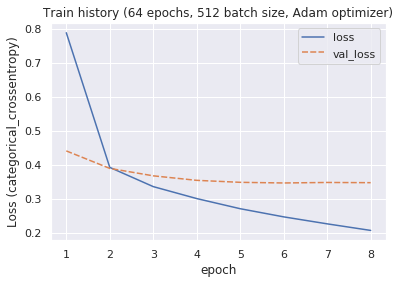

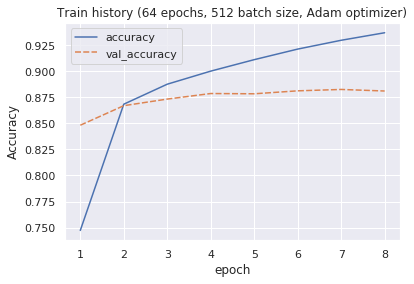

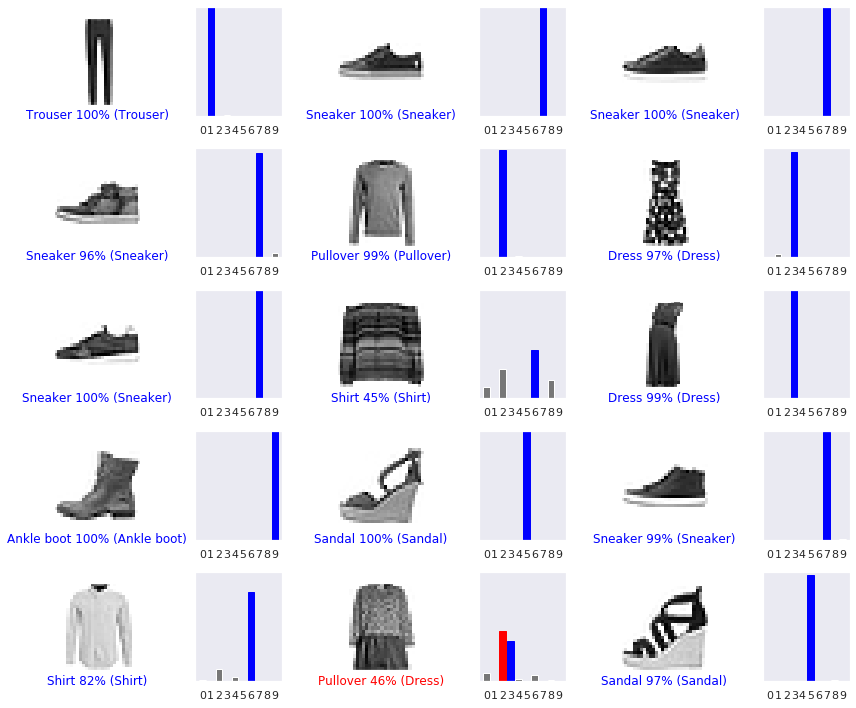

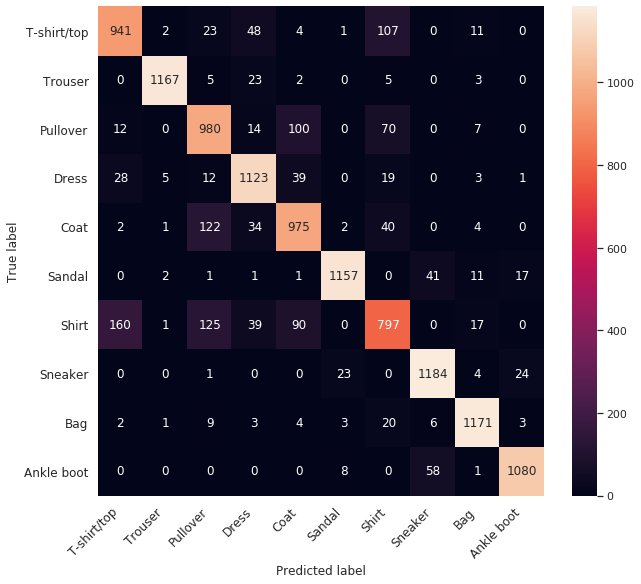

In [58]:
Y_val_99var_pred = train_pca_model(model_99var, pca_99var)

### 2.2. 95% explained variance

In [59]:
model_95var, pca_95var = build_pca_model(min_explained_variance=0.95, model_name="MLP_95var")

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

187 principal components → 0.9501577615737915 explained variance
187 / 784 = 23.85% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 23us/sample - loss: 0.7956 - accuracy: 0.7476 - val_loss: 0.4636 - val_accuracy: 0.8467
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4102 - accuracy: 0.8624 - val_loss: 0.4036 - val_accuracy: 0.8642
Epoch 3/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3619 - accuracy: 0.8772 - val_loss: 0.3734 - val_accuracy: 0.8758
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3313 - accuracy: 0.8875 - val_loss: 0.3617 - val_accuracy: 0.8796
Epoch 5/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3104 - accuracy: 0.8961 - val_loss: 0.3498 - val_accuracy: 0.8812
Epoch 6/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.2921 - accuracy: 0.9025 - val_loss: 0.3457 - val_accuracy: 0.8855
Epoch 7/64
48000/48000 [===========

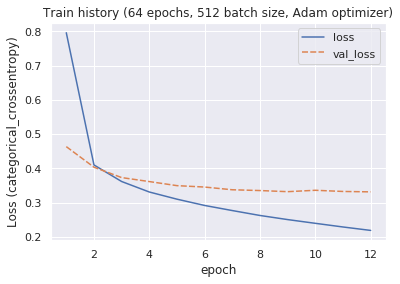

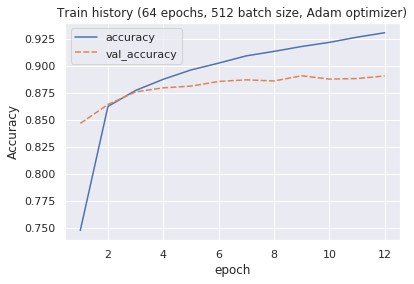

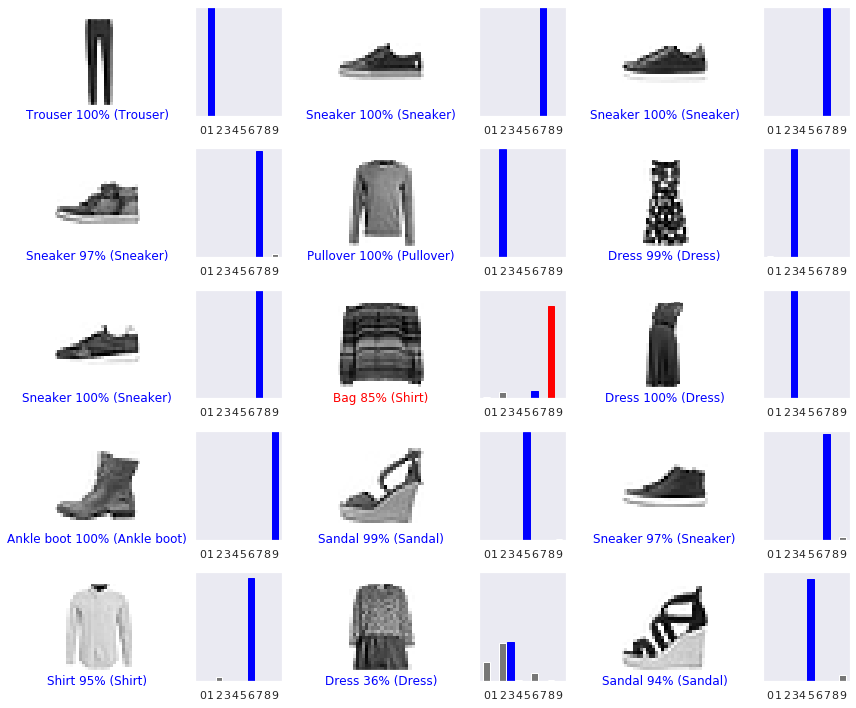

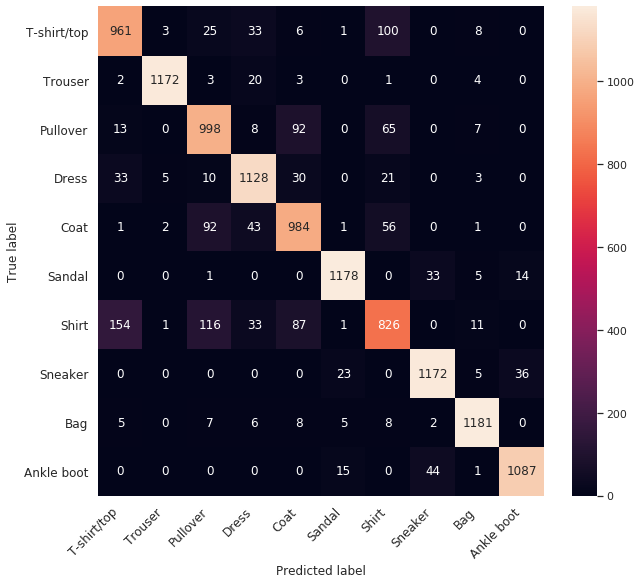

In [60]:
Y_val_95var_pred = train_pca_model(model_95var, pca_95var)

### 2.3. 90% explained variance

In [61]:
model_90var, pca_90var = build_pca_model(min_explained_variance=0.90, model_name="MLP_90var")

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

84 principal components → 0.9006989598274231 explained variance
84 / 784 = 10.71% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 28us/sample - loss: 0.7926 - accuracy: 0.7335 - val_loss: 0.4808 - val_accuracy: 0.8338
Epoch 2/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4360 - accuracy: 0.8522 - val_loss: 0.4155 - val_accuracy: 0.8587
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.3868 - accuracy: 0.8686 - val_loss: 0.3901 - val_accuracy: 0.8669
Epoch 4/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.3596 - accuracy: 0.8783 - val_loss: 0.3730 - val_accuracy: 0.8704
Epoch 5/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.3408 - accuracy: 0.8846 - val_loss: 0.3625 - val_accuracy: 0.8742
Epoch 6/64
48000/48000 [==============================] - 1s 10us/sample - loss: 0.3238 - accuracy: 0.8894 - val_loss: 0.3536 - val_accuracy: 0.8763
Epoch 7/64
48000/48000 [===========

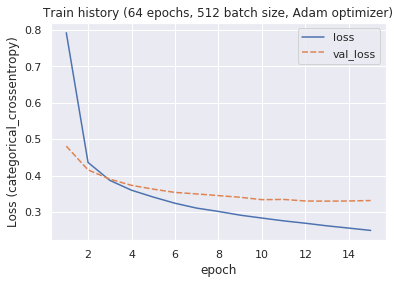

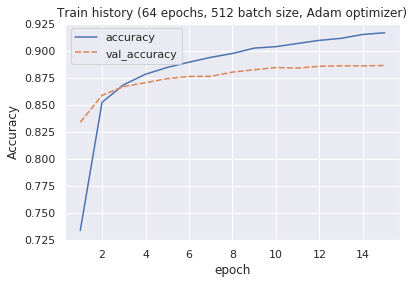

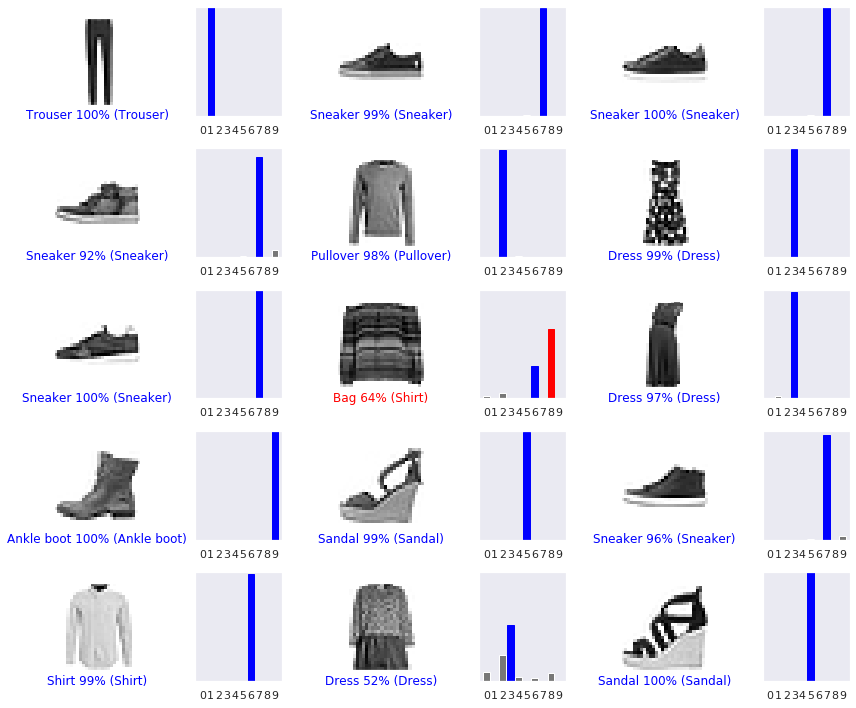

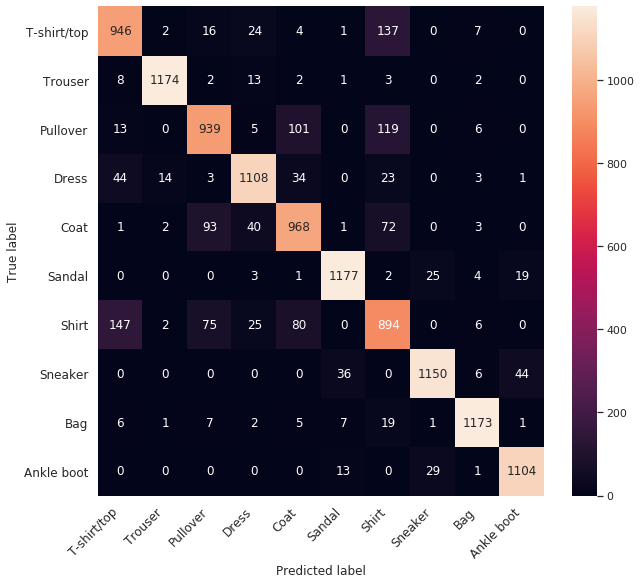

In [62]:
Y_val_90var_pred = train_pca_model(model_90var, pca_90var)

### 2.4. F1-scores

In [0]:
from sklearn.metrics import precision_recall_fscore_support

In [0]:
def print_f1_scores(ys, ys_pred, class_name_dict=CLASS_NAME):
    # ref.: https://github.com/erikperillo/ml-2sem2019/
    def harmonic_mean_of_positive_values(values, eps=1e-18):
        return len(values) / sum(1 / max(v, eps) for v in values)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(ys, ys_pred)
    print("                       Precision    Recall    F1-score")
    for i, (p, r, f1) in enumerate(zip(precision, recall, f1_score)):
        print(f"Class {i} {f'({class_name_dict[i]}):':<16} {p:.4f}  |  {r:.4f}  |  {f1:.4f}")
    print()
    print(f"Combined F1 score:  {harmonic_mean_of_positive_values(f1_score):.4f}")
    print(f"Combined Precision: {harmonic_mean_of_positive_values(precision):.4f}")
    print(f"Combined Recall:    {harmonic_mean_of_positive_values(recall):.4f}")

In [65]:
# MLP baseline
print_f1_scores(ys_val, np.argmax(Y_val_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8128  |  0.8364  |  0.8244
Class 1 (Trouser):       0.9874  |  0.9726  |  0.9799
Class 2 (Pullover):      0.8094  |  0.7971  |  0.8032
Class 3 (Dress):         0.8878  |  0.9073  |  0.8975
Class 4 (Coat):          0.7929  |  0.8500  |  0.8204
Class 5 (Sandal):        0.9592  |  0.9537  |  0.9564
Class 6 (Shirt):         0.7398  |  0.6753  |  0.7061
Class 7 (Sneaker):       0.9258  |  0.9482  |  0.9369
Class 8 (Bag):           0.9650  |  0.9697  |  0.9673
Class 9 (Ankle boot):    0.9624  |  0.9364  |  0.9492

Combined F1 score:  0.8750
Combined Precision: 0.8760
Combined Recall:    0.8741


In [66]:
# CNN baseline
print_f1_scores(ys_val, np.argmax(Y_val_conv_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8286  |  0.8804  |  0.8537
Class 1 (Trouser):       0.9908  |  0.9801  |  0.9854
Class 2 (Pullover):      0.9078  |  0.7904  |  0.8450
Class 3 (Dress):         0.9008  |  0.9228  |  0.9116
Class 4 (Coat):          0.7866  |  0.9059  |  0.8421
Class 5 (Sandal):        0.9779  |  0.9691  |  0.9735
Class 6 (Shirt):         0.7719  |  0.7185  |  0.7442
Class 7 (Sneaker):       0.9641  |  0.9547  |  0.9593
Class 8 (Bag):           0.9824  |  0.9607  |  0.9715
Class 9 (Ankle boot):    0.9589  |  0.9765  |  0.9676

Combined F1 score:  0.8985
Combined Precision: 0.8997
Combined Recall:    0.8973


In [67]:
# 99% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_99var_pred, axis=1), CLASS_NAME) # FIXME why is this worse than 95% ?

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8218  |  0.8276  |  0.8247
Class 1 (Trouser):       0.9898  |  0.9685  |  0.9790
Class 2 (Pullover):      0.7668  |  0.8284  |  0.7964
Class 3 (Dress):         0.8739  |  0.9130  |  0.8930
Class 4 (Coat):          0.8025  |  0.8263  |  0.8142
Class 5 (Sandal):        0.9690  |  0.9399  |  0.9542
Class 6 (Shirt):         0.7533  |  0.6485  |  0.6970
Class 7 (Sneaker):       0.9185  |  0.9579  |  0.9378
Class 8 (Bag):           0.9505  |  0.9583  |  0.9544
Class 9 (Ankle boot):    0.9600  |  0.9416  |  0.9507

Combined F1 score:  0.8706
Combined Precision: 0.8723
Combined Recall:    0.8689


In [68]:
# 95% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_95var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8221  |  0.8452  |  0.8335
Class 1 (Trouser):       0.9907  |  0.9726  |  0.9816
Class 2 (Pullover):      0.7971  |  0.8436  |  0.8197
Class 3 (Dress):         0.8875  |  0.9171  |  0.9020
Class 4 (Coat):          0.8132  |  0.8339  |  0.8234
Class 5 (Sandal):        0.9624  |  0.9569  |  0.9597
Class 6 (Shirt):         0.7669  |  0.6721  |  0.7164
Class 7 (Sneaker):       0.9369  |  0.9482  |  0.9425
Class 8 (Bag):           0.9633  |  0.9664  |  0.9649
Class 9 (Ankle boot):    0.9560  |  0.9477  |  0.9518

Combined F1 score:  0.8813
Combined Precision: 0.8825
Combined Recall:    0.8800


In [69]:
# 90% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_90var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8120  |  0.8320  |  0.8219
Class 1 (Trouser):       0.9824  |  0.9743  |  0.9783
Class 2 (Pullover):      0.8273  |  0.7937  |  0.8102
Class 3 (Dress):         0.9082  |  0.9008  |  0.9045
Class 4 (Coat):          0.8100  |  0.8203  |  0.8152
Class 5 (Sandal):        0.9523  |  0.9561  |  0.9542
Class 6 (Shirt):         0.7045  |  0.7274  |  0.7158
Class 7 (Sneaker):       0.9544  |  0.9304  |  0.9422
Class 8 (Bag):           0.9686  |  0.9599  |  0.9642
Class 9 (Ankle boot):    0.9444  |  0.9625  |  0.9534

Combined F1 score:  0.8774
Combined Precision: 0.8770
Combined Recall:    0.8777


### 2.4. <90% explained variance

### 2.4.1. 80% explained variance

In [70]:
model_80var, pca_80var = build_pca_model(min_explained_variance=0.80, model_name="MLP_80var")

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

24 principal components → 0.8008705377578735 explained variance
24 / 784 = 3.06% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 28us/sample - loss: 0.8727 - accuracy: 0.7103 - val_loss: 0.5456 - val_accuracy: 0.8061
Epoch 2/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.5026 - accuracy: 0.8254 - val_loss: 0.4825 - val_accuracy: 0.8319
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4572 - accuracy: 0.8418 - val_loss: 0.4539 - val_accuracy: 0.8415
Epoch 4/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4313 - accuracy: 0.8507 - val_loss: 0.4345 - val_accuracy: 0.8529
Epoch 5/64
48000/48000 [==============================] - 1s 10us/sample - loss: 0.4148 - accuracy: 0.8564 - val_loss: 0.4277 - val_accuracy: 0.8509
Epoch 6/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4026 - accuracy: 0.8608 - val_loss: 0.4133 - val_accuracy: 0.8575
Epoch 7/64
48000/48000 [===========

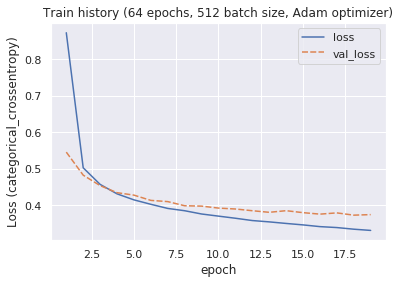

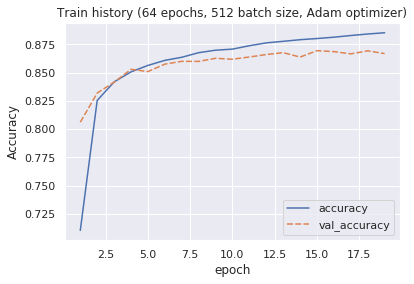

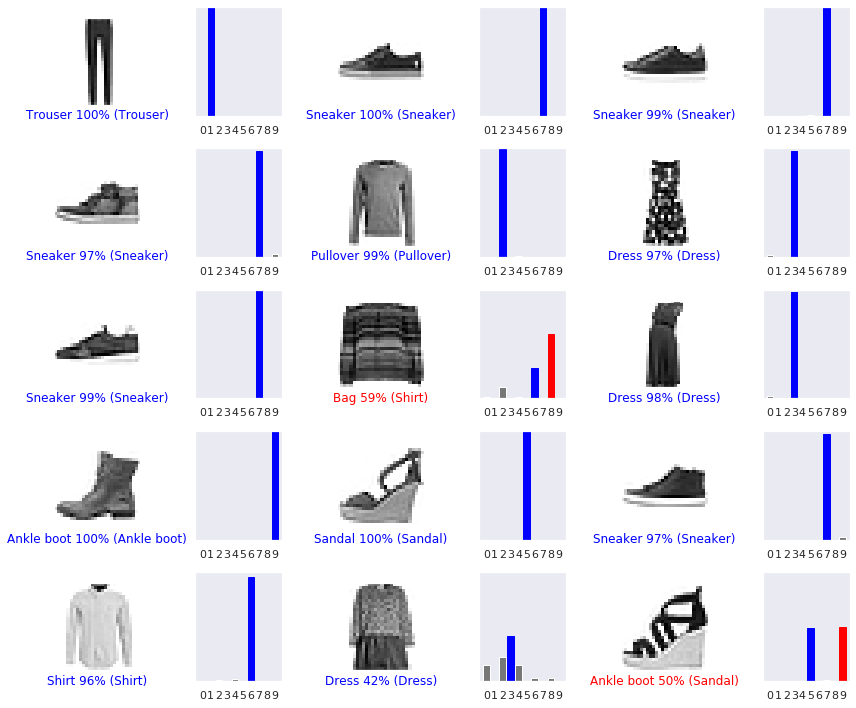

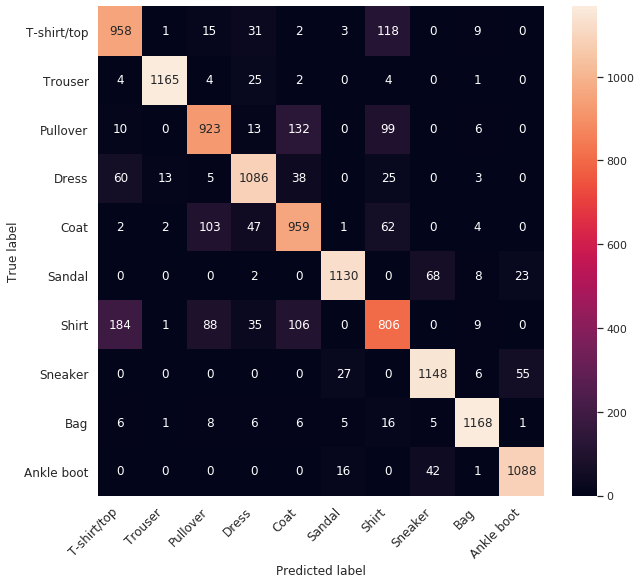

In [71]:
Y_val_80var_pred = train_pca_model(model_80var, pca_80var)

In [72]:
print_f1_scores(ys_val, np.argmax(Y_val_80var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7827  |  0.8426  |  0.8115
Class 1 (Trouser):       0.9848  |  0.9668  |  0.9757
Class 2 (Pullover):      0.8054  |  0.7802  |  0.7926
Class 3 (Dress):         0.8723  |  0.8829  |  0.8776
Class 4 (Coat):          0.7703  |  0.8127  |  0.7909
Class 5 (Sandal):        0.9560  |  0.9180  |  0.9366
Class 6 (Shirt):         0.7133  |  0.6558  |  0.6833
Class 7 (Sneaker):       0.9089  |  0.9288  |  0.9188
Class 8 (Bag):           0.9613  |  0.9558  |  0.9586
Class 9 (Ankle boot):    0.9323  |  0.9486  |  0.9404

Combined F1 score:  0.8585
Combined Precision: 0.8591
Combined Recall:    0.8578


### 2.4.2. 60% explained variance

In [73]:
model_60var, pca_60var = build_pca_model(min_explained_variance=0.60, model_name="MLP_60var")

PCA(copy=True, iterated_power='auto', n_components=0.6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

5 principal components → 0.6156876087188721 explained variance
5 / 784 = 0.64% of components used


Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 28us/sample - loss: 1.0765 - accuracy: 0.6180 - val_loss: 0.7954 - val_accuracy: 0.7037
Epoch 2/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7630 - accuracy: 0.7128 - val_loss: 0.7449 - val_accuracy: 0.7204
Epoch 3/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7284 - accuracy: 0.7246 - val_loss: 0.7187 - val_accuracy: 0.7239
Epoch 4/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7132 - accuracy: 0.7287 - val_loss: 0.7121 - val_accuracy: 0.7312
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.7025 - accuracy: 0.7322 - val_loss: 0.6990 - val_accuracy: 0.7297
Epoch 6/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.6931 - accuracy: 0.7346 - val_loss: 0.6883 - val_accuracy: 0.7356
Epoch 7/64
48000/48000 [===========

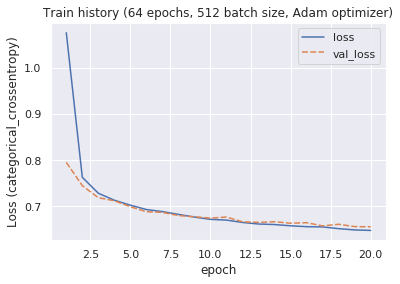

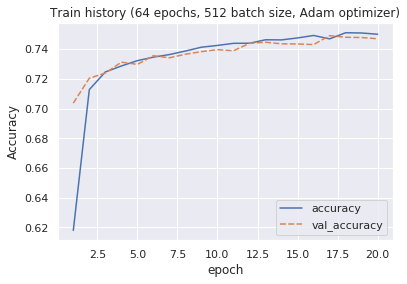

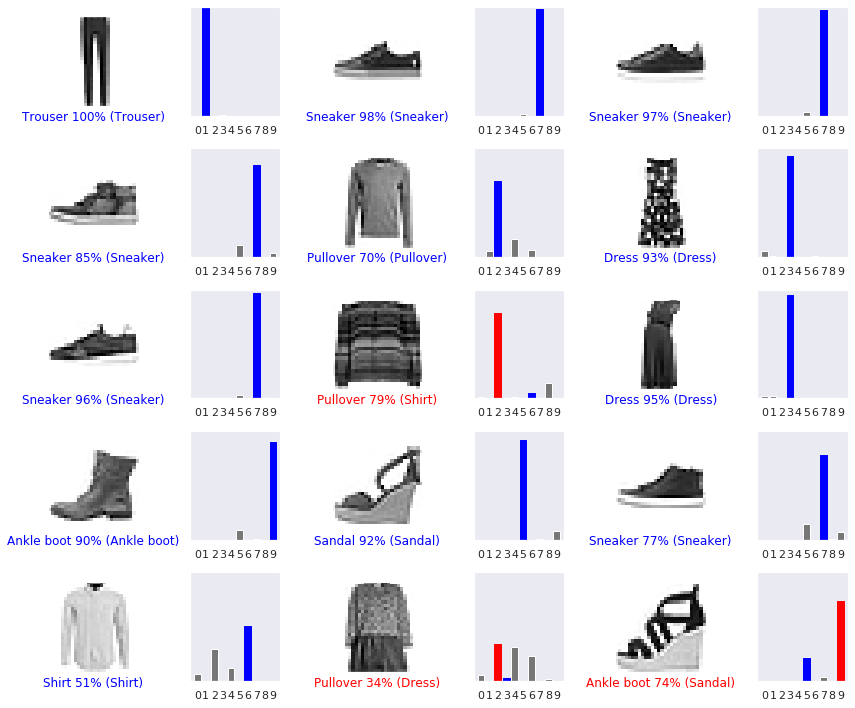

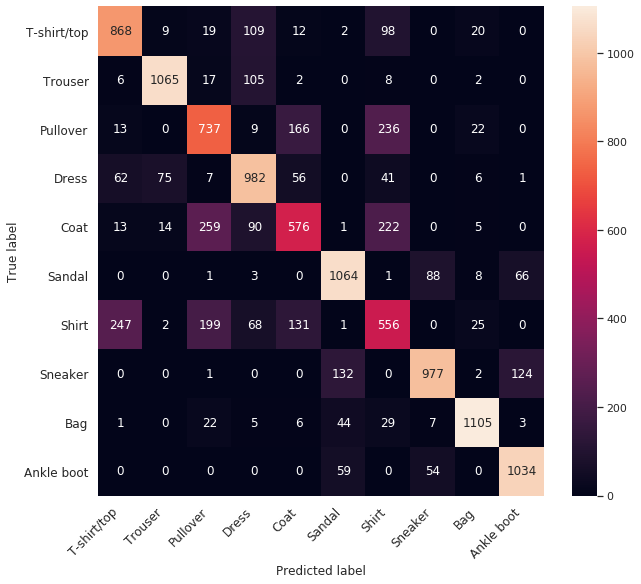

In [74]:
Y_val_60var_pred = train_pca_model(model_60var, pca_60var)

In [75]:
# 60% explained variance
print_f1_scores(ys_val, np.argmax(Y_val_60var_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7174  |  0.7634  |  0.7397
Class 1 (Trouser):       0.9142  |  0.8838  |  0.8987
Class 2 (Pullover):      0.5840  |  0.6230  |  0.6029
Class 3 (Dress):         0.7163  |  0.7984  |  0.7551
Class 4 (Coat):          0.6070  |  0.4881  |  0.5411
Class 5 (Sandal):        0.8166  |  0.8643  |  0.8398
Class 6 (Shirt):         0.4668  |  0.4524  |  0.4595
Class 7 (Sneaker):       0.8677  |  0.7905  |  0.8273
Class 8 (Bag):           0.9247  |  0.9043  |  0.9144
Class 9 (Ankle boot):    0.8420  |  0.9015  |  0.8707

Combined F1 score:  0.7085
Combined Precision: 0.7126
Combined Recall:    0.7045


### 2.5. Plot the first principal components

Out of curiosity, let's visualize the first 2 and 3 components.

In [0]:
pca_3pc = PCA(n_components=3)

In [0]:
pca_3pc_result = pca_3pc.fit_transform(X_train)

In [78]:
print(f"Explained variance per principal component:")
for i, (var, cumsum) in enumerate(zip(pca_3pc.explained_variance_ratio_, np.cumsum(pca_3pc.explained_variance_ratio_))):
    print(f"PC {i+1}: {var:.4f} (cumulative sum: {cumsum:.2f})")

Explained variance per principal component:
PC 1: 0.2896 (cumulative sum: 0.29)
PC 2: 0.1775 (cumulative sum: 0.47)
PC 3: 0.0606 (cumulative sum: 0.53)


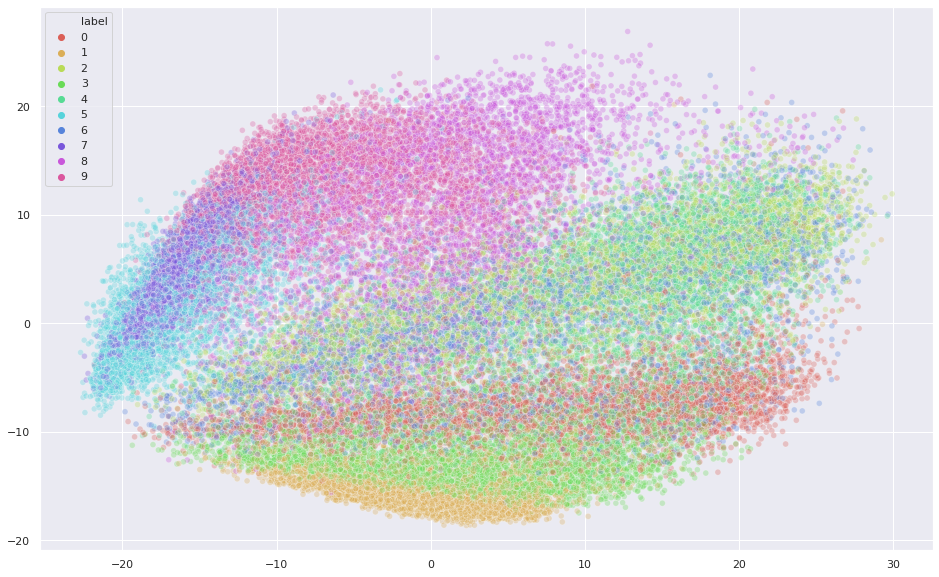

In [79]:
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x=pca_3pc_result[..., 0], # PC 1
    y=pca_3pc_result[..., 1], # PC 2
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=train_dataset,
    legend="full",
    alpha=0.3
)

In [0]:
from mpl_toolkits.mplot3d import Axes3D

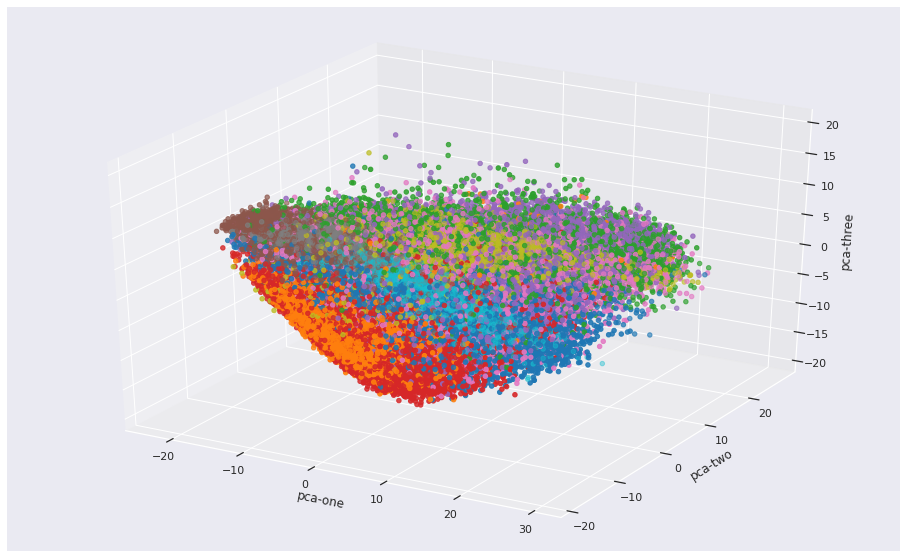

In [81]:
# run '%matplotlib notebook' for an interactive (but laggy) visualization
ax = plt.figure(figsize=(16, 10)).gca(projection='3d')
ax.scatter(
    xs=pca_3pc_result[..., 0], # PC 1
    ys=pca_3pc_result[..., 1], # PC 2
    zs=pca_3pc_result[..., 2], # PC 3
    c=ys_train, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## 3. Using Autoencoders
Re-do the ﬁrst experiment considering Autoencoders for reducing the image dimensionality. Consider two diﬀerent latent vector size for reducing the image dimensionality. What are the conclusions when using Autoencoders in this problem? Does accuracy improve?

Autoencoders are a branch of neural network which attempt to compress the information of the input variables into a reduced dimensional space and then recreate the input data set. Typically the autoencoder is trained over a number of iterations using gradient descent, minimizing the mean squared error. The key component is the “bottleneck” hidden layer. This is where the information from the input has been compressed. By extracting this layer from the model, each node can now be treated as a variable in the same way each chosen principal component is used as a variable in following models.


In [0]:
from tensorflow.keras import Model
# ref.: https://blog.keras.io/building-autoencoders-in-keras.html
#       https://www.tensorflow.org/tutorials/generative/cvae

In [0]:
def build_autoencoder(latent_dim):
    __input   = Input(shape=(784,)) # 28 * 28 = 784 pixels
    __encoded = Dense(latent_dim, activation='relu', activity_regularizer=l1(1e-4))(__input)
    __decoded = Dense(784, activation='sigmoid')(__encoded)

    autoencoder = Model(__input, __decoded)
    print("\nAutoencoder summary:")
    print(autoencoder.summary())

    encoder = Model(__input, __encoded)
    print("\nEncoder summary:")
    print(encoder.summary())

    # create a placeholder for an encoded (24-dimensional) input
    encoded_input = Input(shape=(latent_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]

    decoder = Model(encoded_input, decoder_layer(encoded_input))
    print("\nDecoder summary:")
    print(decoder.summary())

    autoencoder.compile(optimizer='adam', loss='mse')

    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.003, patience=3)]

    autoencoder.fit(X_train, X_train,
                    validation_data=(X_val, X_val),
                    epochs=MAX_EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    callbacks=callbacks,
                    verbose=TF_VERBOSE)
    return autoencoder, encoder, decoder

In [0]:
def show_autoencoder_samples(encoder, decoder):
    encoded_imgs = encoder.predict(X_val)
    decoded_imgs = decoder.predict(encoded_imgs)

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_val[i].reshape(28, 28), cmap='binary')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='binary')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [0]:
def train_ae_model(encoder, latent_dim, model_name):
    model = keras.Sequential([
        Input(shape=(latent_dim, )), # number of components used to keep min_explained_variance
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
    ], model_name)

    model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

    history_ae, best_model_ae = train(model, 
                                      encoder.predict(X_train), Y_train, 
                                      encoder.predict(X_val), Y_val)

    # using ys_val below, instead of np.argmax(Y_val, axis=1), simply for convinence

    Y_val_ae_pred = best_model_ae.predict(encoder.predict(X_val))
    plot_image_with_prediction(X_val, ys_val, Y_val_ae_pred)

    print_cm(ys_val, np.argmax(Y_val_ae_pred, axis=1), CLASS_NAME)
    
    return Y_val_ae_pred, best_model_ae

### 3.1. Latent vector size of 84

In [0]:
latent_dim = 84

In [87]:
autoencoder_84, encoder_84, decoder_84 = build_autoencoder(latent_dim)


Autoencoder summary:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_19 (Dense)             (None, 84)                65940     
_________________________________________________________________
dense_20 (Dense)             (None, 784)               66640     
Total params: 132,580
Trainable params: 132,580
Non-trainable params: 0
_________________________________________________________________
None

Encoder summary:
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_19 (Dense)             (None, 84)                6594

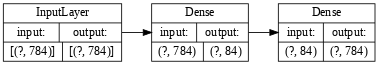

In [88]:
tf.keras.utils.plot_model(autoencoder_84, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60)

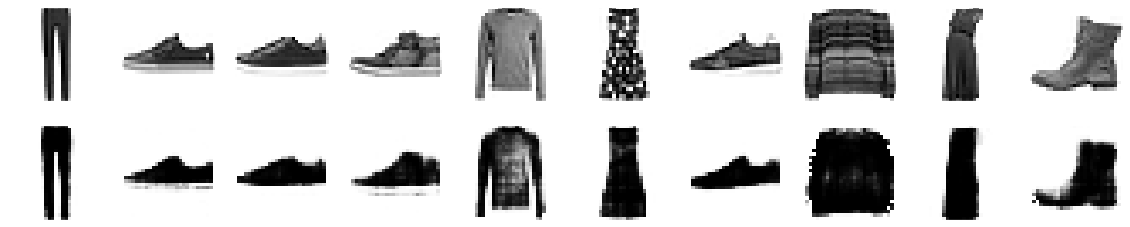

In [89]:
show_autoencoder_samples(encoder_84, decoder_84)

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 22us/sample - loss: 0.8393 - accuracy: 0.7234 - val_loss: 0.5075 - val_accuracy: 0.8225
Epoch 2/64
48000/48000 [==============================] - 1s 10us/sample - loss: 0.4732 - accuracy: 0.8373 - val_loss: 0.4520 - val_accuracy: 0.8422
Epoch 3/64
48000/48000 [==============================] - 1s 10us/sample - loss: 0.4282 - accuracy: 0.8529 - val_loss: 0.4261 - val_accuracy: 0.8503
Epoch 4/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4032 - accuracy: 0.8611 - val_loss: 0.4178 - val_accuracy: 0.8554
Epoch 5/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.3839 - accuracy: 0.8674 - val_loss: 0.3982 - val_accuracy: 0.8597
Epoch 6/64
48000/48000 [==============================] - 1s 10us/sample - loss: 0.3670 - accuracy: 0.8733 - val_loss: 0.3868 - val_accuracy: 0.8637
Epoch 7/64
48000/48000 [===========

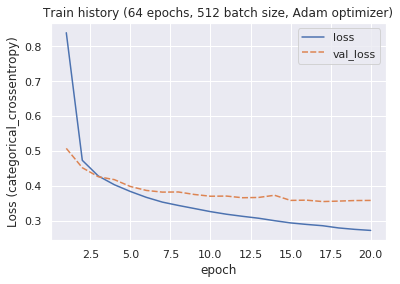

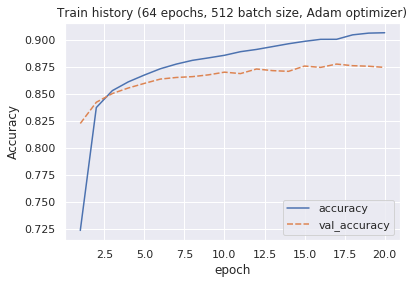

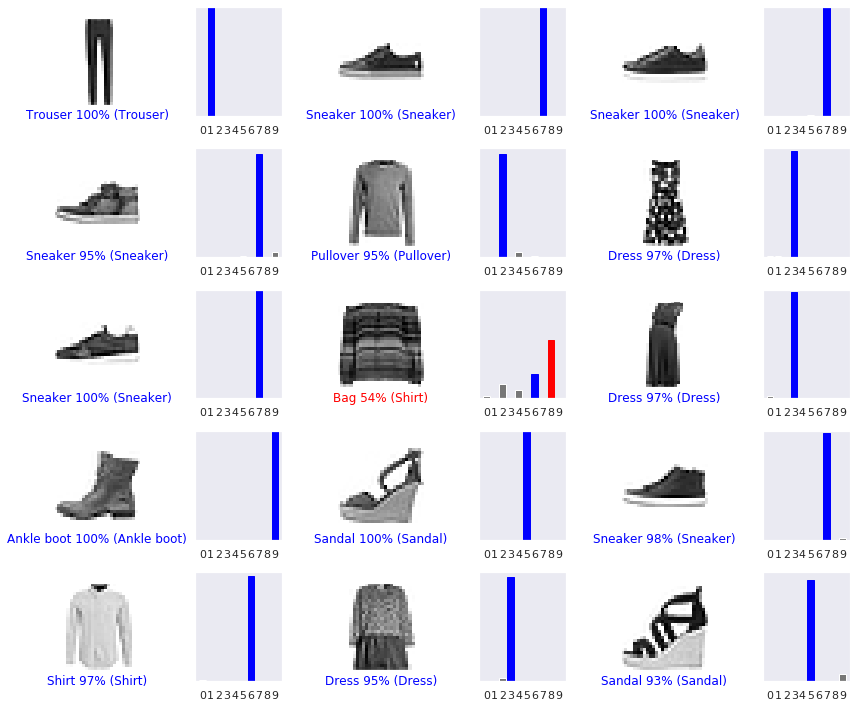

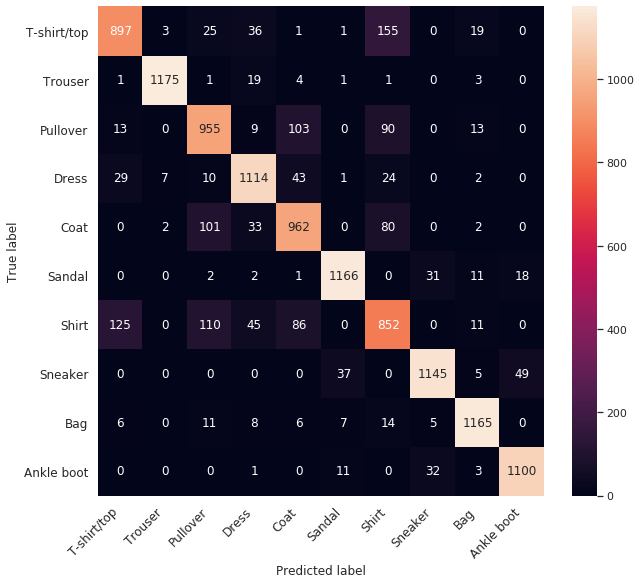

In [90]:
Y_val_ae_84_pred, model_ae_84 = train_ae_model(encoder_84, latent_dim, model_name="AE_84")

In [91]:
print_f1_scores(ys_val, np.argmax(Y_val_ae_84_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.8375  |  0.7889  |  0.8125
Class 1 (Trouser):       0.9899  |  0.9751  |  0.9824
Class 2 (Pullover):      0.7860  |  0.8073  |  0.7965
Class 3 (Dress):         0.8792  |  0.9057  |  0.8923
Class 4 (Coat):          0.7977  |  0.8153  |  0.8064
Class 5 (Sandal):        0.9526  |  0.9472  |  0.9499
Class 6 (Shirt):         0.7007  |  0.6932  |  0.6969
Class 7 (Sneaker):       0.9439  |  0.9264  |  0.9351
Class 8 (Bag):           0.9441  |  0.9534  |  0.9487
Class 9 (Ankle boot):    0.9426  |  0.9590  |  0.9507

Combined F1 score:  0.8675
Combined Precision: 0.8678
Combined Recall:    0.8672


### 3.2. Latent vector size of 24

In [0]:
latent_dim = 24

In [93]:
autoencoder_24, encoder_24, decoder_24 = build_autoencoder(latent_dim)


Autoencoder summary:
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 24)                18840     
_________________________________________________________________
dense_25 (Dense)             (None, 784)               19600     
Total params: 38,440
Trainable params: 38,440
Non-trainable params: 0
_________________________________________________________________
None

Encoder summary:
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_24 (Dense)             (None, 24)                1884

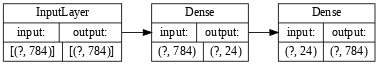

In [94]:
tf.keras.utils.plot_model(autoencoder_24, show_shapes=True, show_layer_names=False, rankdir='LR', dpi=60)

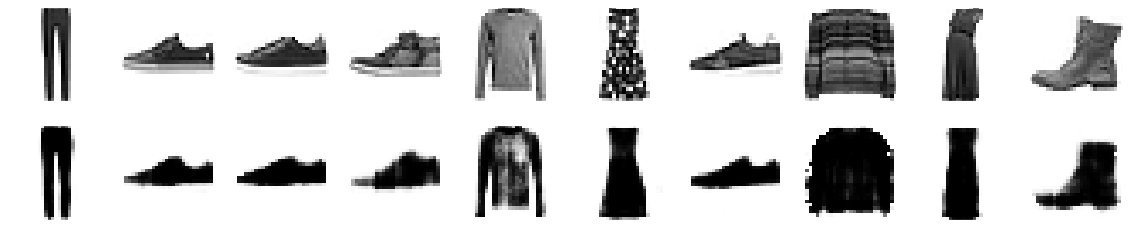

In [95]:
show_autoencoder_samples(encoder_24, decoder_24)

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 1s 22us/sample - loss: 1.1791 - accuracy: 0.6642 - val_loss: 0.5972 - val_accuracy: 0.7935
Epoch 2/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.5488 - accuracy: 0.8089 - val_loss: 0.5078 - val_accuracy: 0.8230
Epoch 3/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4891 - accuracy: 0.8294 - val_loss: 0.4761 - val_accuracy: 0.8337
Epoch 4/64
48000/48000 [==============================] - 0s 10us/sample - loss: 0.4608 - accuracy: 0.8388 - val_loss: 0.4601 - val_accuracy: 0.8406
Epoch 5/64
48000/48000 [==============================] - 1s 11us/sample - loss: 0.4423 - accuracy: 0.8454 - val_loss: 0.4481 - val_accuracy: 0.8414
Epoch 6/64
48000/48000 [==============================] - 1s 10us/sample - loss: 0.4299 - accuracy: 0.8500 - val_loss: 0.4383 - val_accuracy: 0.8460
Epoch 7/64
48000/48000 [===========

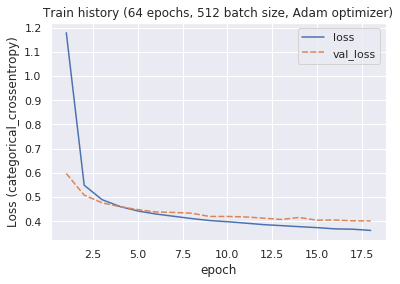

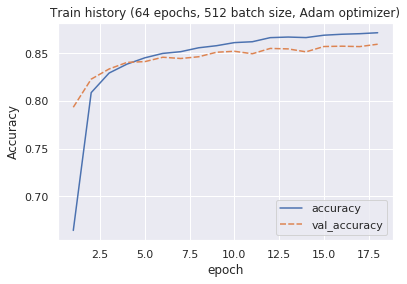

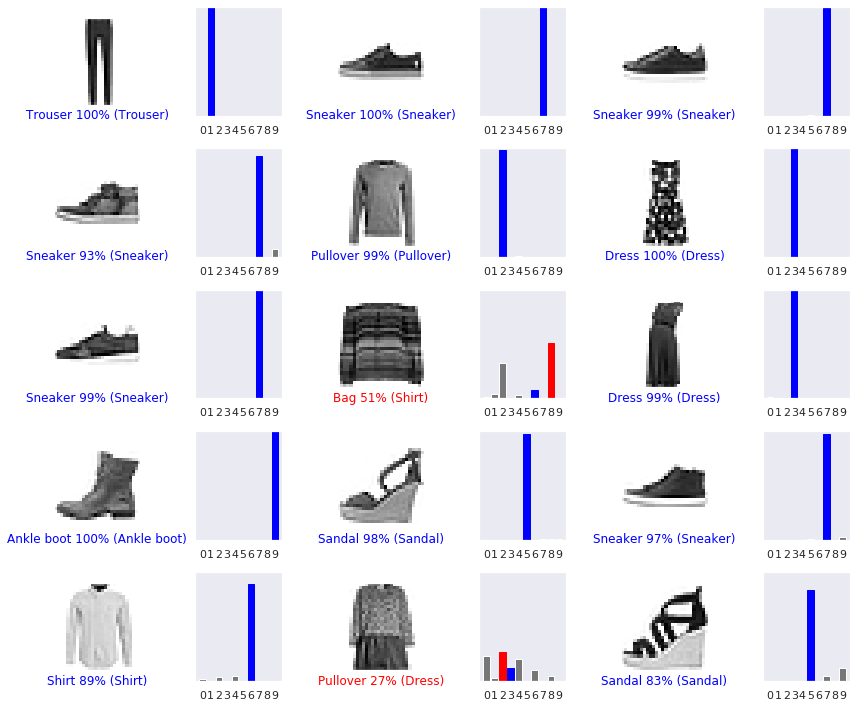

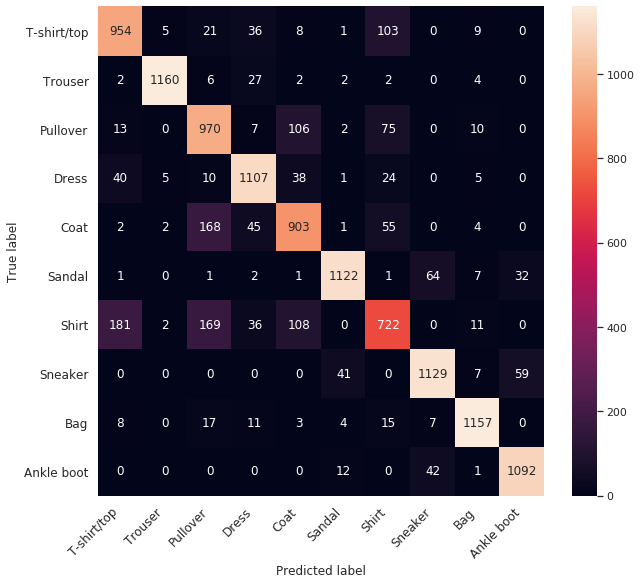

In [96]:
Y_val_ae_24_pred, model_ae_24 = train_ae_model(encoder_24, latent_dim, model_name="AE_24")

In [97]:
print_f1_scores(ys_val, np.argmax(Y_val_ae_24_pred, axis=1), CLASS_NAME)

                       Precision    Recall    F1-score
Class 0 (T-shirt/top):   0.7943  |  0.8391  |  0.8161
Class 1 (Trouser):       0.9881  |  0.9627  |  0.9752
Class 2 (Pullover):      0.7122  |  0.8199  |  0.7623
Class 3 (Dress):         0.8710  |  0.9000  |  0.8852
Class 4 (Coat):          0.7725  |  0.7653  |  0.7688
Class 5 (Sandal):        0.9460  |  0.9115  |  0.9284
Class 6 (Shirt):         0.7242  |  0.5875  |  0.6487
Class 7 (Sneaker):       0.9090  |  0.9134  |  0.9112
Class 8 (Bag):           0.9523  |  0.9468  |  0.9495
Class 9 (Ankle boot):    0.9231  |  0.9520  |  0.9373

Combined F1 score:  0.8454
Combined Precision: 0.8482
Combined Recall:    0.8425


## 4. Using clustering techniques
Explore two clustering algorithms using the reduced features (PCA or Autoencoders). Do the clusters make sense? Check the validity/quality of your clusters.

In [0]:
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, v_measure_score, silhouette_score

In [0]:
def show_clusters(clusters, data):
    # [-1.0, 1.0], with 1.0 being the perfect score, and 0.0 being random
    print(f"  Adjusted Rand Score:    {adjusted_rand_score(labels_true=ys_val, labels_pred=clusters.labels_):.3f}")
    # [0.0, 1.0], harmonic mean between homogeneity and completeness scores (higher is better)
    print(f"  V-measure Score:        {v_measure_score(labels_true=ys_val, labels_pred=clusters.labels_):.3f}")
    # [-1.0, 1.0], with 1.0 for highly dense clustering, 0.0 indicate overlapping clusters, and -1.0 for incorrect clustering
    print(f"  Silhouette Coefficient: {silhouette_score(X=data, labels=clusters.labels_):.3f}")

    labels = clusters.labels_.astype(float)
    # we select the first two feature columns for plotting in 2D
    __xs, __ys = data[..., 0], data[..., 1]

    try:
        centroids = clusters.cluster_centers_ # K-Means and Mini-Batch K-Means
        __xc, __yc = centroids[..., 0], centroids[..., 1]
    except:
        centroids = None
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=__xs, y=__ys, 
                    hue=labels, palette=sns.color_palette("hls", 10), alpha=0.3)
    if centroids is not None:
        sns.scatterplot(x=__xc, y=__yc, 
                        marker='+', s=175, linewidths=3, color='black', zorder=10)
    plt.show()

Let's standardize the features we'll be using for clustering with Z-score:

In [172]:
reduced_features_list = [("X_val_80var", pca_80var.transform(X_val)), ("X_val_90var", pca_90var.transform(X_val))]
                      # [("X_val_ae_24", encoder_24.predict(X_val)), ("X_val_ae_84", encoder_84.predict(X_val))]
reduced_features_zscore = []
for name, reduced_features in reduced_features_list:
    print(f"{name+':':<19} {str(reduced_features.shape):<11} "
          f"| min: {reduced_features.min():>6.2f} | max: {reduced_features.max():>6.2f} "
          f"| mean: {reduced_features.mean():>6.3f} | std: {reduced_features.std():>6.3f}")
    reduced_features_zscore.append((name + "_zscore", (reduced_features - reduced_features.mean()) / reduced_features.std()))
for name, reduced_features in reduced_features_zscore:
    print(f"{name+':':<19} {str(reduced_features.shape):<11} "
          f"| min: {reduced_features.min():>6.2f} | max: {reduced_features.max():>6.2f} "
          f"| mean: {reduced_features.mean():>6.3f} | std: {reduced_features.std():>6.3f}")

X_val_80var:        (12000, 24) | min: -22.32 | max:  30.72 | mean: -0.003 | std:  4.271
X_val_90var:        (12000, 84) | min: -22.32 | max:  30.72 | mean: -0.001 | std:  2.421
X_val_80var_zscore: (12000, 24) | min:  -5.23 | max:   7.19 | mean:  0.000 | std:  1.000
X_val_90var_zscore: (12000, 84) | min:  -9.22 | max:  12.69 | mean:  0.000 | std:  1.000


In [0]:
X_val_80var_zscore, X_val_90var_zscore = reduced_features_zscore[0][1], reduced_features_zscore[1][1]

## 4.1. K-Means

### 4.1.1. PCA reduced features (90% explained variance, 84 principal components)

  Adjusted Rand Score:    0.381
  V-measure Score:        0.526
  Silhouette Coefficient: 0.183


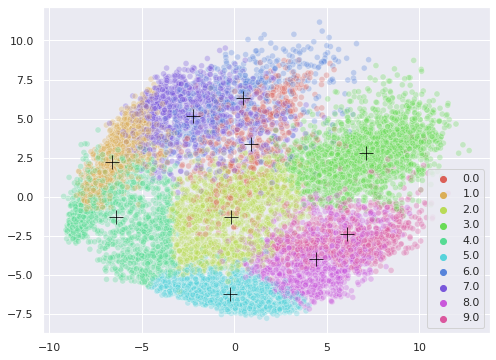

In [174]:
kmeans_pca_90var = KMeans(n_clusters=10).fit(X_val_90var_zscore)
show_clusters(kmeans_pca_90var, X_val_90var_zscore)

### 4.1.2. PCA reduced features (80% explained variance, 24 principal components)

  Adjusted Rand Score:    0.369
  V-measure Score:        0.510
  Silhouette Coefficient: 0.221


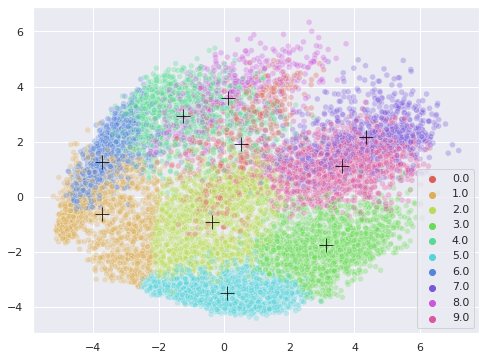

In [175]:
kmeans_pca_80var = KMeans(n_clusters=10).fit(X_val_80var_zscore)
show_clusters(kmeans_pca_80var, X_val_80var_zscore)

## 4.2. Mini-Batch K-Means

### 4.2.1. PCA reduced features (90% explained variance, 84 principal components)

  Adjusted Rand Score:    0.337
  V-measure Score:        0.501
  Silhouette Coefficient: 0.185


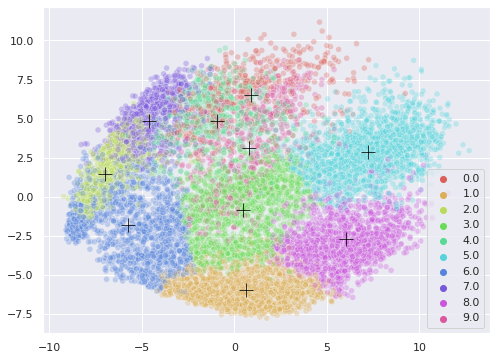

In [176]:
mbkmeans_pca_90var = MiniBatchKMeans(n_clusters=10).fit(X_val_90var_zscore)
show_clusters(mbkmeans_pca_90var, X_val_90var_zscore)

### 4.2.2. PCA reduced features (80% explained variance, 24 principal components)

  Adjusted Rand Score:    0.328
  V-measure Score:        0.484
  Silhouette Coefficient: 0.216


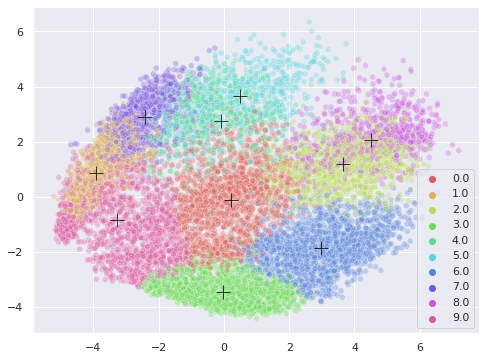

In [177]:
mbkmeans_pca_80var = MiniBatchKMeans(n_clusters=10).fit(X_val_80var_zscore)
show_clusters(mbkmeans_pca_80var, X_val_80var_zscore)

## 4.3. Agglomerative clustering

### 4.3.1. PCA reduced features (90% explained variance, 84 principal components)

  Adjusted Rand Score:    0.342
  V-measure Score:        0.499
  Silhouette Coefficient: 0.148


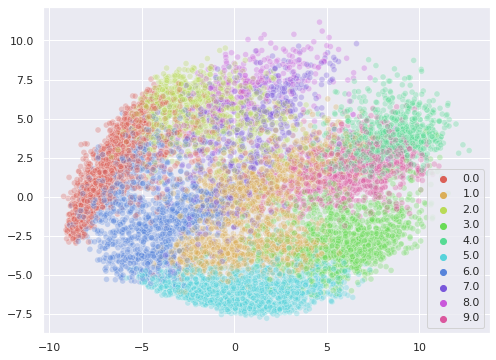

In [178]:
agglomerative_pca_90var = AgglomerativeClustering(n_clusters=10).fit(X_val_90var_zscore)
show_clusters(agglomerative_pca_90var, X_val_90var_zscore)

### 4.3.2. PCA reduced features (80% explained variance, 24 principal components)

  Adjusted Rand Score:    0.383
  V-measure Score:        0.548
  Silhouette Coefficient: 0.183


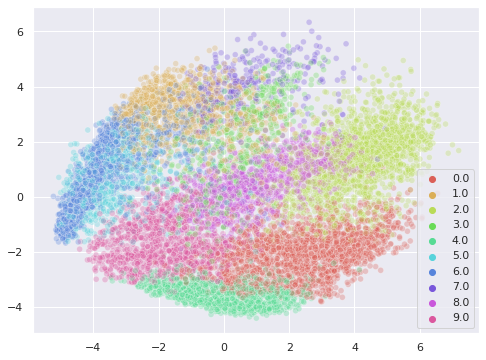

In [179]:
agglomerative_pca_80var = AgglomerativeClustering(n_clusters=10).fit(X_val_80var_zscore)
show_clusters(agglomerative_pca_80var, X_val_80var_zscore)

In [180]:
strftime('%X')

'19:06:50'